# Time-Series Cross-Validation — Threshold Formula Evaluation

**Goal:** Evaluate 25 threshold formulas (6 base metrics × 4 rolling windows + `price_move`)
using expanding-window time-series CV with coverage-filtered folds. Find which
formula most consistently produces ~600 signals/month across all validation folds.

**Improvements over `threshold_analysis.ipynb`:**
- Replaces single 50/50 split with multi-fold expanding-window CV
- Explores 4 rolling windows (6, 12, 24, 48 candles = 30min–4h)
- Replaces useless `taker_imbalance` with `momentum_spike` (Bollinger-style deviation)
- Filters out folds/months with low symbol coverage (≥80% required)
- Adds forward fluctuation as a signal quality ranking criterion

## Section 0: Setup & Constants

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import os, csv
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats as sp_stats
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from tqdm.auto import tqdm

# Plot style
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams.update({
    "figure.figsize": (14, 6),
    "figure.dpi": 100,
    "savefig.dpi": 150,
    "savefig.bbox": "tight",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
})

# Constants
DATA_DIR = Path("../data")
OUTPUT_DIR = Path("output")
OUTPUT_DIR.mkdir(exist_ok=True)

MIN_ROWS = 52_000              # ~6 months of 5m candles
TARGET_SIGNALS_MONTH = 600     # target signals per month across all symbols
N_SEGMENTS = 12                # number of time segments
N_FOLDS = N_SEGMENTS - 1       # 11 expanding-window folds
MIN_COVERAGE_RATIO = 0.80      # minimum fraction of symbols required in a month/fold
N_FORWARD = 24                 # forward candles for fluctuation metric (2 hours of 5m candles)

# Multi-window configuration: 30min, 1h, 2h, 4h in 5m candles
WINDOWS = [6, 12, 24, 48]

# Build METRIC_COLS dynamically: 6 window-sensitive bases × 4 windows + price_move
_BASE_METRICS = ["vol_spike", "range_spike", "trade_spike", "qvol_spike", "combined_z",
                 "momentum_spike"]
METRIC_COLS = [f"{base}_{w}" for base in _BASE_METRICS for w in WINDOWS] + ["price_move"]

print(f"Setup complete. N_SEGMENTS={N_SEGMENTS}, N_FOLDS={N_FOLDS}")
print(f"Windows: {WINDOWS} ({len(WINDOWS)} windows)")
print(f"N_FORWARD: {N_FORWARD} candles ({N_FORWARD * 5} min)")
print(f"Metrics: {len(METRIC_COLS)} total ({len(_BASE_METRICS)} bases × {len(WINDOWS)} windows + price_move)")

Setup complete. N_SEGMENTS=12, N_FOLDS=11
Windows: [6, 12, 24, 48] (4 windows)
N_FORWARD: 24 candles (120 min)
Metrics: 25 total (6 bases × 4 windows + price_move)


## Section 1: Data Loading

In [2]:
# --- Load all perpetual USDT 5m CSVs ---
all_csvs = sorted(DATA_DIR.glob("*/5m.csv"))
print(f"Found {len(all_csvs)} symbols with 5m.csv")

raw_frames = {}
for csv_path in tqdm(all_csvs, desc="Loading CSVs"):
    sym = csv_path.parent.name
    if "_" in sym or sym.endswith("BUSD"):
        continue
    df = pd.read_csv(
        csv_path,
        names=["open_time", "open", "high", "low", "close", "volume",
               "close_time", "quote_volume", "trades",
               "taker_buy_volume", "taker_buy_quote_volume"],
        header=0,
        dtype={"open": str, "high": str, "low": str, "close": str,
               "volume": str, "quote_volume": str,
               "taker_buy_volume": str, "taker_buy_quote_volume": str},
    )
    if len(df) < MIN_ROWS:
        continue
    for col in ["open", "high", "low", "close", "volume", "quote_volume",
                "taker_buy_volume", "taker_buy_quote_volume"]:
        df[col] = df[col].astype(float)
    df["trades"] = df["trades"].astype(int)
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    df = df.sort_values("open_time").reset_index(drop=True)
    raw_frames[sym] = df

symbols = sorted(raw_frames.keys())
print(f"\n{len(symbols)} symbols passed filters (>= {MIN_ROWS} rows, perpetual USDT)")

Found 162 symbols with 5m.csv


Loading CSVs:   0%|          | 0/162 [00:00<?, ?it/s]


118 symbols passed filters (>= 52000 rows, perpetual USDT)


## Section 2: Compute 25 Threshold Metrics on Full Data

6 base metrics × 4 rolling windows (6, 12, 24, 48 candles) + `price_move` = 25 metrics.

| Base Metric | Column Pattern | Intuition |
|-------------|---------------|-----------|
| Volume Spike | `vol_spike_{w}` | Sudden participation surge |
| Range Spike | `range_spike_{w}` | Volatility explosion |
| Trade Count Spike | `trade_spike_{w}` | Retail frenzy |
| Quote Vol Spike | `qvol_spike_{w}` | USD value surge |
| Combined Z-Score | `combined_z_{w}` | Multi-dimension confirmation |
| Momentum Spike | `momentum_spike_{w}` | Bollinger-style price deviation |
| Price Move | `price_move` | Candle body magnitude (window-independent) |

All metrics use backward-looking rolling/expanding windows — no look-ahead bias.
`fwd_fluctuation` is forward-looking but only used for quality ranking, never for threshold selection.

In [3]:
def compute_threshold_metrics_for_window(df: pd.DataFrame, window: int) -> pd.DataFrame:
    """Add 6 metric columns for a given rolling window size."""
    s = str(window)

    # Volume spike: current volume / rolling mean
    vol_rm = df["volume"].rolling(window, min_periods=1).mean()
    df[f"vol_spike_{s}"] = df["volume"] / vol_rm.replace(0, np.nan)

    # Range spike: (high-low)/open normalized by its rolling mean
    range_ratio = (df["high"] - df["low"]) / df["open"].replace(0, np.nan)
    range_rm = range_ratio.rolling(window, min_periods=1).mean()
    df[f"range_spike_{s}"] = range_ratio / range_rm.replace(0, np.nan)

    # Trade count spike
    trades_rm = df["trades"].rolling(window, min_periods=1).mean()
    df[f"trade_spike_{s}"] = df["trades"] / trades_rm.replace(0, np.nan)

    # Quote volume spike
    qvol_rm = df["quote_volume"].rolling(window, min_periods=1).mean()
    df[f"qvol_spike_{s}"] = df["quote_volume"] / qvol_rm.replace(0, np.nan)

    # Combined z-score: expanding standardization of avg(vol_spike, range_spike)
    vol_col = df[f"vol_spike_{s}"].fillna(1)
    range_col = df[f"range_spike_{s}"].fillna(1)
    raw_combo = (vol_col + range_col) / 2
    exp_mean = raw_combo.expanding(min_periods=window).mean()
    exp_std = raw_combo.expanding(min_periods=window).std()
    df[f"combined_z_{s}"] = (raw_combo - exp_mean) / exp_std.replace(0, np.nan)

    # Momentum spike: Bollinger-style deviation of close price
    close_rm = df["close"].rolling(window, min_periods=1).mean()
    close_rs = df["close"].rolling(window, min_periods=1).std()
    df[f"momentum_spike_{s}"] = (df["close"] - close_rm).abs() / close_rs.replace(0, np.nan)

    return df


def compute_all_metrics(df: pd.DataFrame, windows: list[int], n_forward: int) -> pd.DataFrame:
    """Add all 25 metric columns + fwd_fluctuation to a DataFrame."""
    # Window-sensitive metrics (6 bases × N windows)
    for w in windows:
        df = compute_threshold_metrics_for_window(df, w)

    # Window-independent metric
    df["price_move"] = (df["close"] - df["open"]).abs() / df["open"].replace(0, np.nan)

    # Forward fluctuation: avg |return| over next n_forward candles (for quality ranking only)
    close = df["close"].values
    n = len(close)
    fwd_fluct = np.full(n, np.nan)
    for i in range(n - n_forward):
        if close[i] == 0:
            continue
        total = 0.0
        for j in range(1, n_forward + 1):
            total += abs(close[i + j] - close[i]) / close[i]
        fwd_fluct[i] = total / n_forward
    df["fwd_fluctuation"] = fwd_fluct

    return df


for sym in tqdm(symbols, desc="Computing metrics"):
    raw_frames[sym] = compute_all_metrics(raw_frames[sym], WINDOWS, N_FORWARD)

print(f"Metrics computed on full data for {len(symbols)} symbols.")
print(f"Total metric columns: {len(METRIC_COLS)}")
print(f"Sample columns: {METRIC_COLS[:5]} ... {METRIC_COLS[-3:]}")

Computing metrics:   0%|          | 0/118 [00:00<?, ?it/s]

Metrics computed on full data for 118 symbols.
Total metric columns: 25
Sample columns: ['vol_spike_6', 'vol_spike_12', 'vol_spike_24', 'vol_spike_48', 'range_spike_6'] ... ['momentum_spike_24', 'momentum_spike_48', 'price_move']


## Section 3: Define 12 Global Time Segments

Global time range: 2020-01-01 00:00:00 — 2022-06-30 23:55:00
Total duration: 911 days 23:55:00
  Segment  1: 2020-01-01 — 2020-03-16
  Segment  2: 2020-03-16 — 2020-05-31
  Segment  3: 2020-05-31 — 2020-08-15
  Segment  4: 2020-08-15 — 2020-10-30
  Segment  5: 2020-10-30 — 2021-01-14
  Segment  6: 2021-01-14 — 2021-03-31
  Segment  7: 2021-03-31 — 2021-06-15
  Segment  8: 2021-06-15 — 2021-08-30
  Segment  9: 2021-08-30 — 2021-11-14
  Segment 10: 2021-11-14 — 2022-01-29
  Segment 11: 2022-01-29 — 2022-04-15
  Segment 12: 2022-04-15 — 2022-06-30


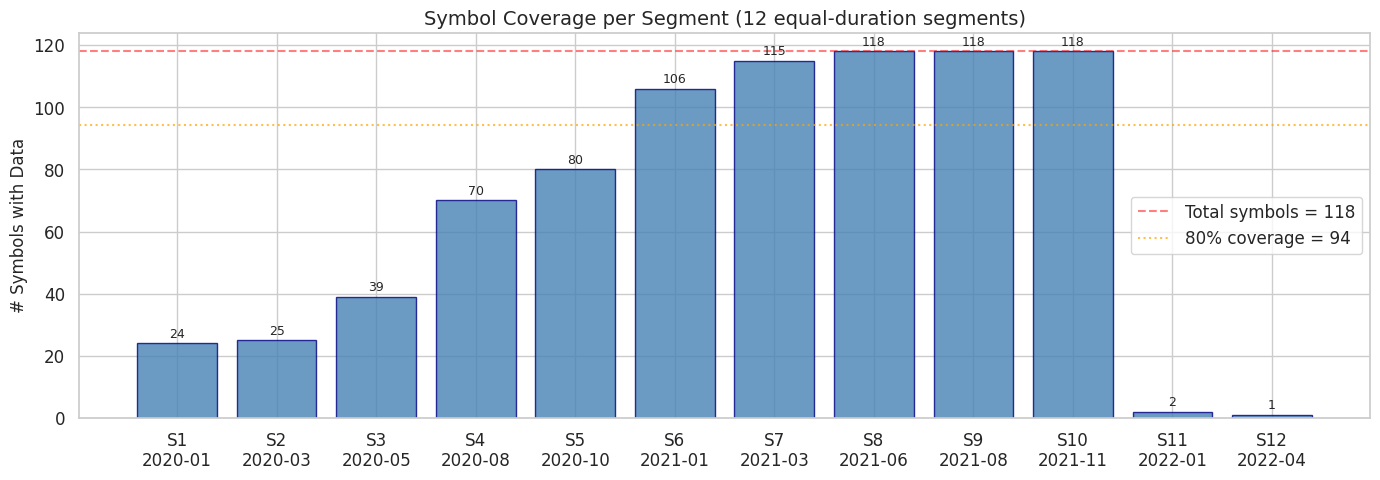

Saved cv_segment_coverage.png
TOTAL_SYMBOLS = 118, MIN_COVERAGE_RATIO = 0.8


In [4]:
# --- Global min/max open_time across all symbols ---
global_min = min(df["open_time"].iloc[0] for df in raw_frames.values())
global_max = max(df["open_time"].iloc[-1] for df in raw_frames.values())
print(f"Global time range: {global_min} — {global_max}")
print(f"Total duration: {global_max - global_min}")

# --- Create N_SEGMENTS equal-duration boundaries ---
segment_boundaries = pd.date_range(start=global_min, end=global_max, periods=N_SEGMENTS + 1)
segments = []
for i in range(N_SEGMENTS):
    segments.append((segment_boundaries[i], segment_boundaries[i + 1]))
    print(f"  Segment {i+1:2d}: {segment_boundaries[i].strftime('%Y-%m-%d')} — "
          f"{segment_boundaries[i+1].strftime('%Y-%m-%d')}")

# --- Count symbols with data in each segment ---
segment_coverage = []
for seg_idx, (seg_start, seg_end) in enumerate(segments):
    count = 0
    for sym in symbols:
        df = raw_frames[sym]
        mask = (df["open_time"] >= seg_start) & (df["open_time"] < seg_end)
        if mask.sum() > 0:
            count += 1
    segment_coverage.append(count)

TOTAL_SYMBOLS = len(symbols)

# --- Bar chart: symbol coverage per segment ---
fig, ax = plt.subplots(figsize=(14, 5))
seg_labels = [f"S{i+1}\n{s.strftime('%Y-%m')}" for i, (s, _) in enumerate(segments)]
bars = ax.bar(seg_labels, segment_coverage, color="steelblue", alpha=0.8, edgecolor="navy")
ax.set_ylabel("# Symbols with Data")
ax.set_title(f"Symbol Coverage per Segment ({N_SEGMENTS} equal-duration segments)")
ax.axhline(TOTAL_SYMBOLS, color="red", ls="--", alpha=0.5, label=f"Total symbols = {TOTAL_SYMBOLS}")
coverage_threshold = TOTAL_SYMBOLS * MIN_COVERAGE_RATIO
ax.axhline(coverage_threshold, color="orange", ls=":", alpha=0.7,
           label=f"{MIN_COVERAGE_RATIO:.0%} coverage = {coverage_threshold:.0f}")
for bar, cov in zip(bars, segment_coverage):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
            str(cov), ha="center", va="bottom", fontsize=9)
ax.legend()
plt.tight_layout()
fig.savefig(OUTPUT_DIR / "cv_segment_coverage.png")
plt.show()
print(f"Saved cv_segment_coverage.png")
print(f"TOTAL_SYMBOLS = {TOTAL_SYMBOLS}, MIN_COVERAGE_RATIO = {MIN_COVERAGE_RATIO}")

## Section 4: Helper Functions, Sweep Ranges & Valid Folds

In [5]:
def get_fold_frames(raw_frames: dict, segments: list, fold_idx: int):
    """Return (train_frames, val_frames) for expanding-window fold.

    fold_idx: 0-based (0..N_FOLDS-1)
    Train = segments 0..fold_idx, Val = segment fold_idx+1
    """
    train_end = segments[fold_idx][1]
    val_start = segments[fold_idx + 1][0]
    val_end = segments[fold_idx + 1][1]

    train_frames_out = {}
    val_frames_out = {}
    for sym, df in raw_frames.items():
        train_mask = df["open_time"] < train_end
        val_mask = (df["open_time"] >= val_start) & (df["open_time"] < val_end)
        tr = df[train_mask]
        va = df[val_mask]
        if len(tr) > 0:
            train_frames_out[sym] = tr
        if len(va) > 0:
            val_frames_out[sym] = va
    return train_frames_out, val_frames_out


def get_valid_months(frames: dict, total_symbols: int, min_ratio: float) -> set:
    """Return set of month periods where >= min_ratio of total_symbols have data."""
    month_sym_count = defaultdict(int)
    for sym, df in frames.items():
        months_present = df["open_time"].dt.to_period("M").unique()
        for m in months_present:
            month_sym_count[m] += 1
    threshold = total_symbols * min_ratio
    return {m for m, cnt in month_sym_count.items() if cnt >= threshold}


def count_signals_per_month(frames: dict, metric: str, threshold: float,
                            valid_months: set | None = None) -> pd.Series:
    """Count total signals per month across all symbols for a given metric & threshold.
    If valid_months is provided, only count signals in those months."""
    monthly_counts = defaultdict(int)
    for sym in frames:
        df = frames[sym]
        triggered = df[df[metric] >= threshold]
        months = triggered["open_time"].dt.to_period("M")
        for m, cnt in months.value_counts().items():
            if valid_months is None or m in valid_months:
                monthly_counts[m] += cnt
    if not monthly_counts:
        return pd.Series(dtype=float)
    return pd.Series(monthly_counts).sort_index()


def find_best_threshold(frames: dict, metric: str, thresholds: np.ndarray,
                        target: float = TARGET_SIGNALS_MONTH,
                        valid_months: set | None = None) -> tuple:
    """Sweep thresholds, return (best_threshold, avg_signals_per_month)."""
    best_t = thresholds[0]
    best_diff = float("inf")
    best_avg = 0.0
    for t in thresholds:
        monthly = count_signals_per_month(frames, metric, t, valid_months)
        if len(monthly) > 0:
            avg = monthly.mean()
            diff = abs(avg - target)
            if diff < best_diff:
                best_diff = diff
                best_t = round(t, 4)
                best_avg = avg
    return best_t, best_avg


# --- Base sweep ranges (mapped by base metric name) ---
_base_ranges = {
    "vol_spike":       np.arange(1.5, 6.1, 0.25),
    "range_spike":     np.arange(1.5, 6.1, 0.25),
    "trade_spike":     np.arange(1.5, 6.1, 0.25),
    "qvol_spike":      np.arange(1.5, 6.1, 0.25),
    "combined_z":      np.arange(0.5, 4.1, 0.25),
    "momentum_spike":  np.arange(0.5, 4.1, 0.25),
    "price_move":      np.arange(0.002, 0.021, 0.001),
}

# Build sweep_ranges for all 25 metrics
sweep_ranges = {}
for metric in METRIC_COLS:
    if metric == "price_move":
        sweep_ranges[metric] = _base_ranges["price_move"]
    else:
        # e.g. "momentum_spike_12" -> base="momentum_spike", window="12"
        base = metric.rsplit("_", 1)[0]
        sweep_ranges[metric] = _base_ranges[base]

# --- Precompute valid folds (val segment has >= MIN_COVERAGE_RATIO of total symbols) ---
valid_folds = []
for fold_idx in range(N_FOLDS):
    _, val_f = get_fold_frames(raw_frames, segments, fold_idx)
    ratio = len(val_f) / TOTAL_SYMBOLS
    is_valid = ratio >= MIN_COVERAGE_RATIO
    status = "VALID" if is_valid else "SKIP"
    print(f"  Fold {fold_idx+1:2d}: val_syms={len(val_f):3d}/{TOTAL_SYMBOLS} "
          f"({ratio:.1%}) -> {status}")
    if is_valid:
        valid_folds.append(fold_idx)

print(f"\nValid folds: {len(valid_folds)}/{N_FOLDS} "
      f"(indices: {[f+1 for f in valid_folds]})")
print(f"Sweep sizes: {len(sweep_ranges)} metrics")
print(f"  Example: vol_spike_6={len(sweep_ranges['vol_spike_6'])}, "
      f"price_move={len(sweep_ranges['price_move'])}")

  Fold  1: val_syms= 25/118 (21.2%) -> SKIP


  Fold  2: val_syms= 39/118 (33.1%) -> SKIP


  Fold  3: val_syms= 70/118 (59.3%) -> SKIP


  Fold  4: val_syms= 80/118 (67.8%) -> SKIP


  Fold  5: val_syms=106/118 (89.8%) -> VALID


  Fold  6: val_syms=115/118 (97.5%) -> VALID


  Fold  7: val_syms=118/118 (100.0%) -> VALID


  Fold  8: val_syms=118/118 (100.0%) -> VALID


  Fold  9: val_syms=118/118 (100.0%) -> VALID
  Fold 10: val_syms=  2/118 (1.7%) -> SKIP


  Fold 11: val_syms=  1/118 (0.8%) -> SKIP

Valid folds: 5/11 (indices: [5, 6, 7, 8, 9])
Sweep sizes: 25 metrics
  Example: vol_spike_6=19, price_move=20


## Section 5: Main CV Loop — Valid Folds × 25 Metrics

Only folds with ≥80% symbol coverage in the validation segment are used.
Within each fold, months with low coverage are also filtered out.

In [6]:
cv_results = []

for fold_idx in valid_folds:
    train_f, val_f = get_fold_frames(raw_frames, segments, fold_idx)
    train_rows = sum(len(v) for v in train_f.values())
    val_rows = sum(len(v) for v in val_f.values())

    # Precompute valid months — compare against symbols actually in each frame set,
    # not TOTAL_SYMBOLS (early folds have fewer training symbols than the global total)
    train_valid_months = get_valid_months(train_f, len(train_f), MIN_COVERAGE_RATIO)
    val_valid_months = get_valid_months(val_f, len(val_f), MIN_COVERAGE_RATIO)

    print(f"\nFold {fold_idx+1}/{N_FOLDS}: train={len(train_f)} syms ({train_rows:,} rows), "
          f"val={len(val_f)} syms ({val_rows:,} rows)")
    print(f"  Valid months — train: {len(train_valid_months)}, val: {len(val_valid_months)}")

    for metric in tqdm(METRIC_COLS, desc=f"Fold {fold_idx+1}", leave=False):
        thresholds = sweep_ranges[metric]

        # Find best threshold on training data (using valid months only)
        best_t, train_avg = find_best_threshold(
            train_f, metric, thresholds, valid_months=train_valid_months
        )

        # Evaluate on training data
        train_monthly = count_signals_per_month(train_f, metric, best_t, train_valid_months)
        train_avg = train_monthly.mean() if len(train_monthly) > 0 else 0
        train_cv = (train_monthly.std() / train_avg * 100) if train_avg > 0 else np.nan

        # Evaluate on validation segment
        val_monthly = count_signals_per_month(val_f, metric, best_t, val_valid_months)
        val_avg = val_monthly.mean() if len(val_monthly) > 0 else 0
        val_cv = (val_monthly.std() / val_avg * 100) if val_avg > 0 else np.nan

        # Drift
        drift_pct = ((val_avg - train_avg) / train_avg * 100) if train_avg > 0 else np.nan

        # Forward fluctuation: mean fwd_fluctuation of triggered val candles
        # Average per-symbol first, then across symbols (prevents high-volume symbol dominance)
        sym_flucts = []
        for sym in val_f:
            df_sym = val_f[sym]
            triggered_mask = df_sym[metric] >= best_t
            fluct_vals = df_sym.loc[triggered_mask, "fwd_fluctuation"].dropna()
            if len(fluct_vals) > 0:
                sym_flucts.append(fluct_vals.mean())
        mean_fwd_fluct = np.mean(sym_flucts) if sym_flucts else np.nan

        cv_results.append({
            "fold": fold_idx + 1,
            "metric": metric,
            "threshold": best_t,
            "train_syms": len(train_f),
            "val_syms": len(val_f),
            "train_avg": round(train_avg, 1),
            "val_avg": round(val_avg, 1),
            "drift_pct": round(drift_pct, 1) if not np.isnan(drift_pct) else np.nan,
            "train_cv_pct": round(train_cv, 1) if not np.isnan(train_cv) else np.nan,
            "val_cv_pct": round(val_cv, 1) if not np.isnan(val_cv) else np.nan,
            "mean_fwd_fluct": round(mean_fwd_fluct, 6) if not np.isnan(mean_fwd_fluct) else np.nan,
        })

cv_df = pd.DataFrame(cv_results)
cv_df.to_csv(OUTPUT_DIR / "threshold_cv_results.csv", index=False)
n_valid = len(valid_folds)
print(f"\nSaved threshold_cv_results.csv ({len(cv_df)} rows: "
      f"{n_valid} valid folds x {len(METRIC_COLS)} metrics)")
cv_df.head(14)


Fold 5/11: train=80 syms (4,419,341 rows), val=106 syms (1,987,331 rows)
  Valid months — train: 4, val: 3


Fold 5:   0%|          | 0/25 [00:00<?, ?it/s]


Fold 6/11: train=106 syms (6,406,672 rows), val=115 syms (2,446,673 rows)
  Valid months — train: 3, val: 3


Fold 6:   0%|          | 0/25 [00:00<?, ?it/s]


Fold 7/11: train=115 syms (8,853,345 rows), val=118 syms (2,570,850 rows)
  Valid months — train: 5, val: 3


Fold 7:   0%|          | 0/25 [00:00<?, ?it/s]


Fold 8/11: train=118 syms (11,424,195 rows), val=118 syms (2,582,784 rows)
  Valid months — train: 6, val: 4


Fold 8:   0%|          | 0/25 [00:00<?, ?it/s]


Fold 9/11: train=118 syms (14,006,979 rows), val=118 syms (1,610,235 rows)
  Valid months — train: 9, val: 2


Fold 9:   0%|          | 0/25 [00:00<?, ?it/s]


Saved threshold_cv_results.csv (125 rows: 5 valid folds x 25 metrics)


,fold,metric,threshold,train_syms,val_syms,train_avg,val_avg,drift_pct,train_cv_pct,val_cv_pct,mean_fwd_fluct
0,5,vol_spike_6,4.75,80,106,618.0,237.0,-61.7,62.3,43.5,0.018551
1,5,vol_spike_12,6.00,80,106,1637.2,734.7,-55.1,55.2,37.6,0.017281
2,5,vol_spike_24,6.00,80,106,3636.5,2009.3,-44.7,47.1,27.2,0.019699
3,5,vol_spike_48,6.00,80,106,5092.5,3374.3,-33.7,42.8,30.9,0.021275
4,5,range_spike_6,3.50,80,106,415.2,291.7,-29.8,60.4,65.1,0.020355
5,5,range_spike_12,4.25,80,106,633.5,467.0,-26.3,56.9,66.2,0.022766
6,5,range_spike_24,5.00,80,106,622.8,454.0,-27.1,53.7,47.4,0.027897
7,5,range_spike_48,5.75,80,106,571.5,458.3,-19.8,51.8,51.3,0.032122
8,5,trade_spike_6,4.00,80,106,649.2,430.3,-33.7,63.1,46.5,0.019228
9,5,trade_spike_12,5.75,80,106,580.8,457.3,-21.3,60.7,54.4,0.019893


## Section 6: Threshold Stability Across Folds (Top 10)

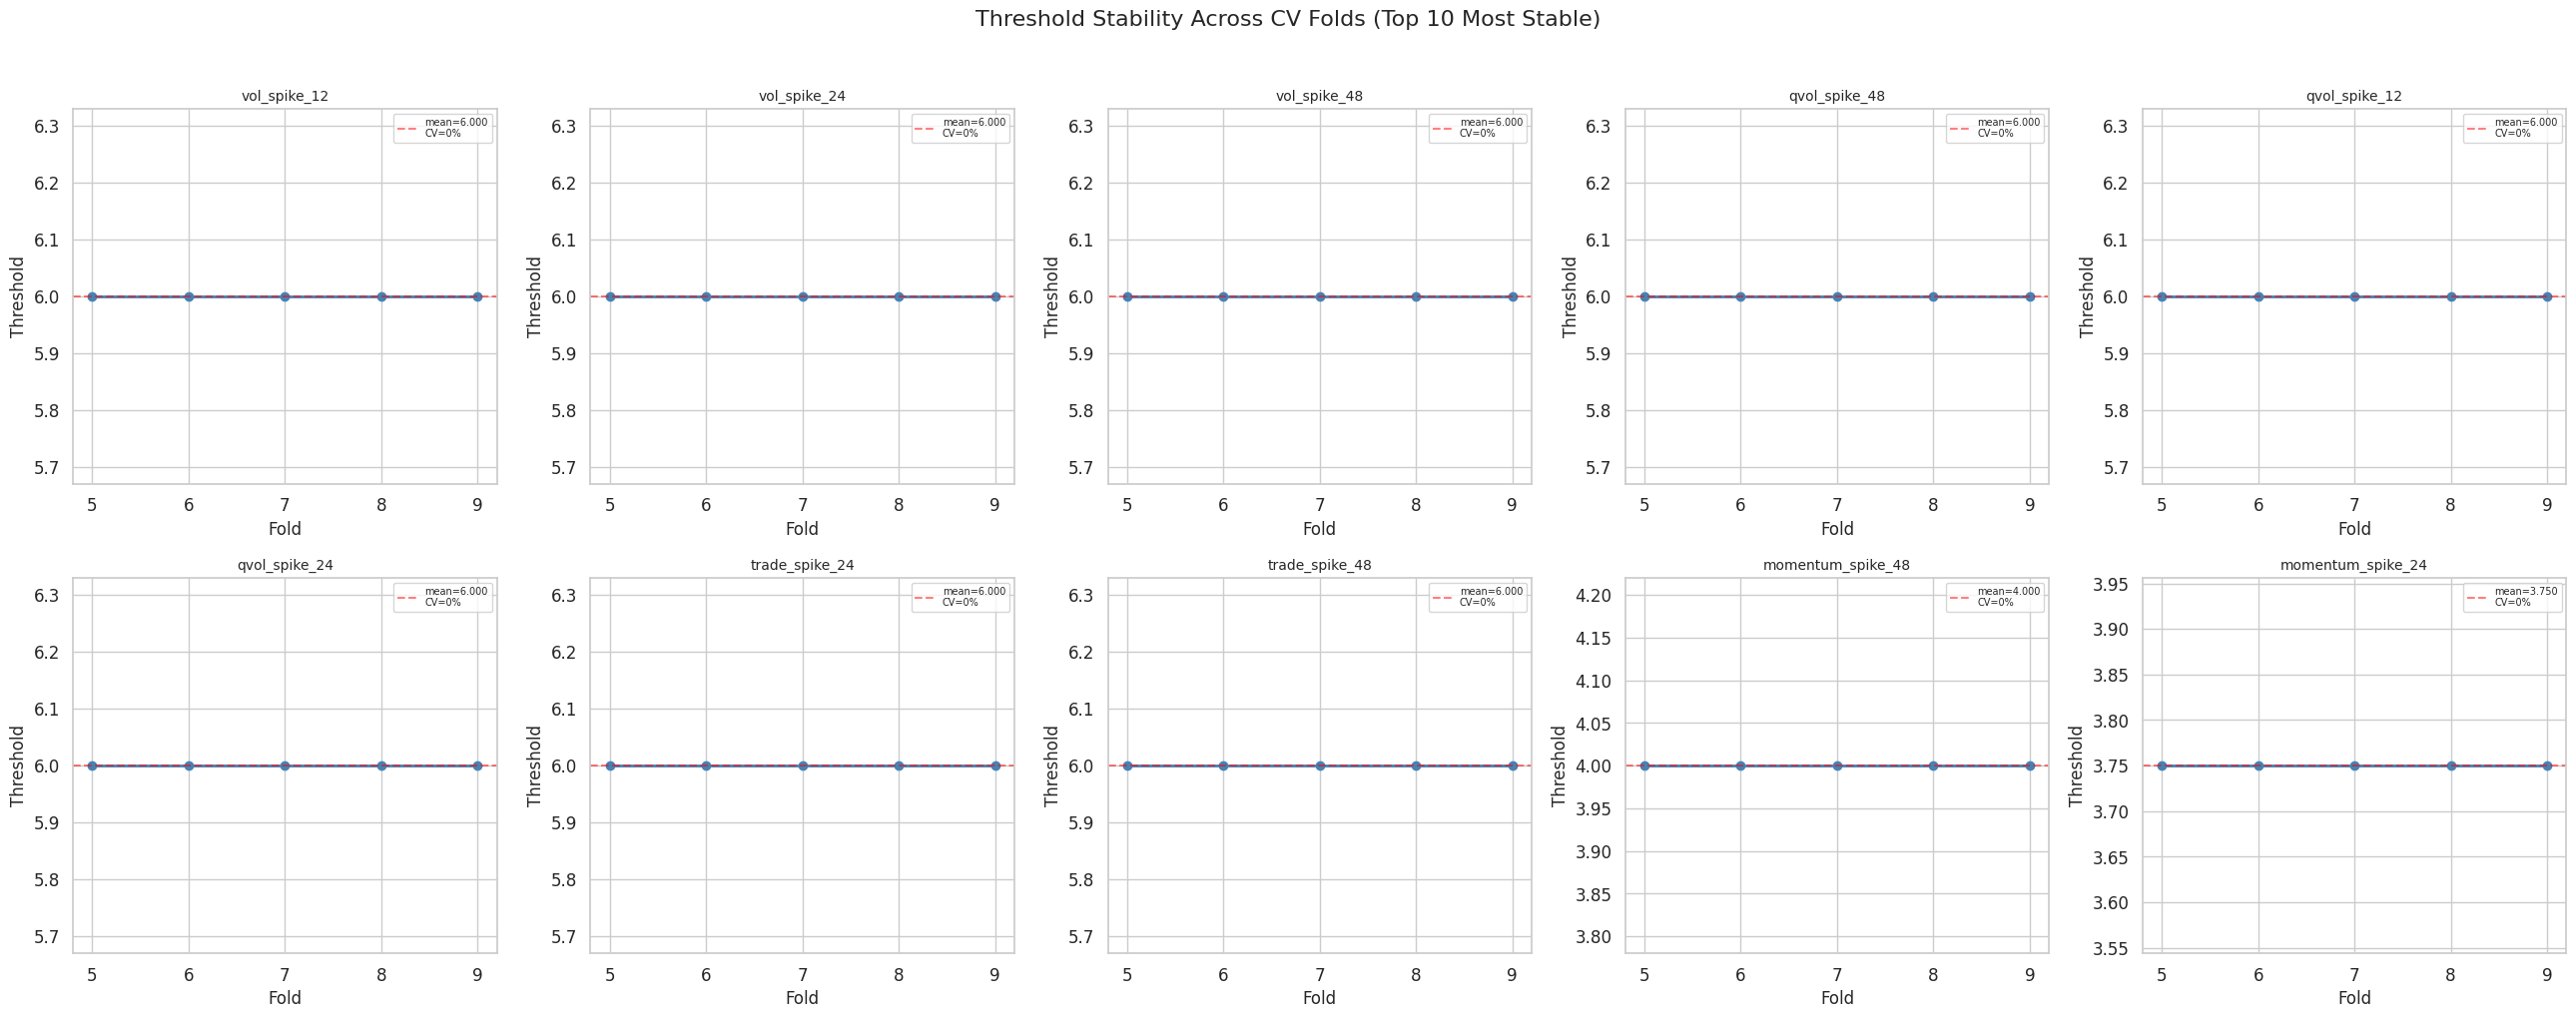

Saved cv_threshold_stability.png

Threshold consistency — all metrics (lower CV% = more stable):


,t_mean,t_std,t_cv_pct,t_min,t_max
metric,,,,,
vol_spike_12,6.000,0.0000,0.0,6.000,6.000
vol_spike_24,6.000,0.0000,0.0,6.000,6.000
vol_spike_48,6.000,0.0000,0.0,6.000,6.000
qvol_spike_48,6.000,0.0000,0.0,6.000,6.000
qvol_spike_12,6.000,0.0000,0.0,6.000,6.000
qvol_spike_24,6.000,0.0000,0.0,6.000,6.000
trade_spike_24,6.000,0.0000,0.0,6.000,6.000
trade_spike_48,6.000,0.0000,0.0,6.000,6.000
momentum_spike_48,4.000,0.0000,0.0,4.000,4.000


In [7]:
# --- Compute threshold stability stats for all metrics ---
threshold_stats = []
for metric in METRIC_COLS:
    mdf = cv_df[cv_df["metric"] == metric]
    t_mean = mdf["threshold"].mean()
    t_std = mdf["threshold"].std()
    t_cv = (t_std / t_mean * 100) if t_mean > 0 else np.nan
    threshold_stats.append({
        "metric": metric,
        "t_mean": round(t_mean, 4),
        "t_std": round(t_std, 4),
        "t_cv_pct": round(t_cv, 1) if not np.isnan(t_cv) else np.nan,
        "t_min": mdf["threshold"].min(),
        "t_max": mdf["threshold"].max(),
    })

tstats_df = pd.DataFrame(threshold_stats).set_index("metric")
top10_stable = tstats_df.sort_values("t_cv_pct").head(10).index.tolist()

# --- Line plot: threshold chosen per fold for top 10 most stable metrics ---
fig, axes = plt.subplots(2, 5, figsize=(26, 10))
axes = axes.flatten()

fold_numbers = [f + 1 for f in valid_folds]

for i, metric in enumerate(top10_stable):
    ax = axes[i]
    mdf = cv_df[cv_df["metric"] == metric]
    ax.plot(mdf["fold"], mdf["threshold"], marker="o", linewidth=2, color="steelblue")
    ax.fill_between(mdf["fold"], mdf["threshold"].min(), mdf["threshold"].max(),
                    alpha=0.1, color="steelblue")
    ax.set_title(metric, fontsize=10)
    ax.set_xlabel("Fold")
    ax.set_ylabel("Threshold")
    ax.set_xticks(fold_numbers)

    t_mean = tstats_df.loc[metric, "t_mean"]
    t_cv = tstats_df.loc[metric, "t_cv_pct"]
    ax.axhline(t_mean, color="red", ls="--", alpha=0.5,
               label=f"mean={t_mean:.3f}\nCV={t_cv:.0f}%")
    ax.legend(fontsize=7)

fig.suptitle("Threshold Stability Across CV Folds (Top 10 Most Stable)", fontsize=16, y=1.02)
plt.tight_layout()
fig.savefig(OUTPUT_DIR / "cv_threshold_stability.png")
plt.show()
print("Saved cv_threshold_stability.png")

# --- Full threshold CV% table ---
print("\nThreshold consistency — all metrics (lower CV% = more stable):")
tstats_df.sort_values("t_cv_pct")

## Section 7: Validation Signal Counts — Heatmap & Line Plot (Top 10)

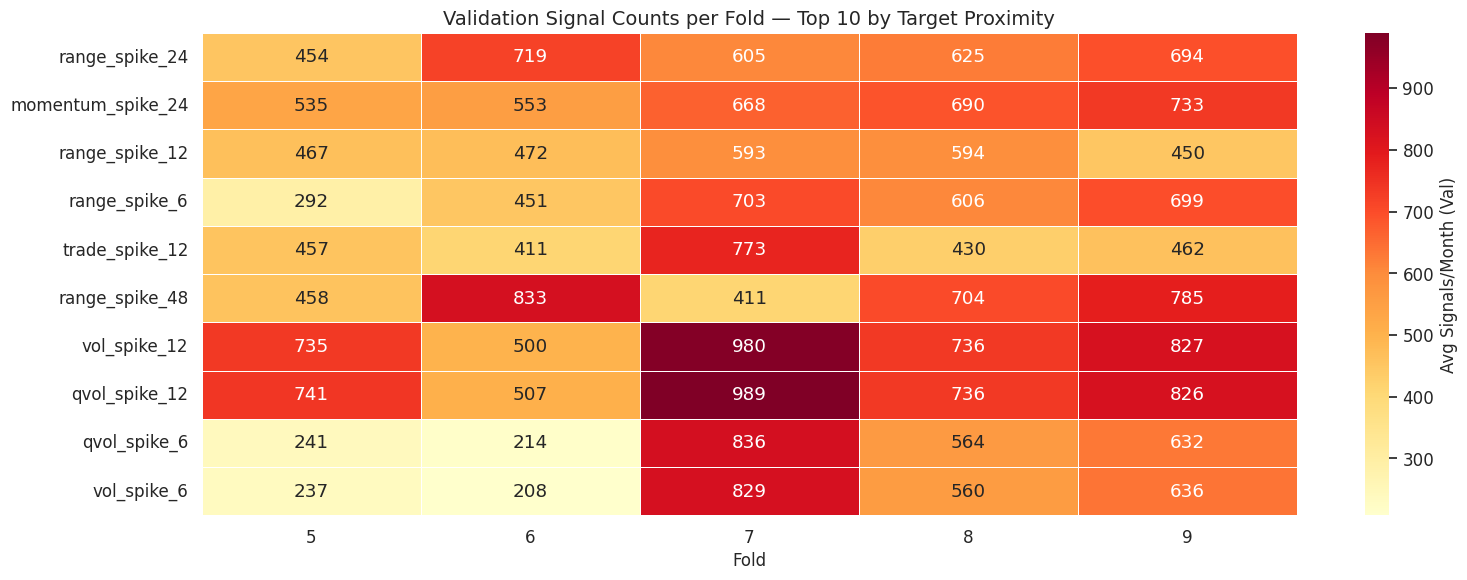

Saved cv_val_signals_heatmap.png


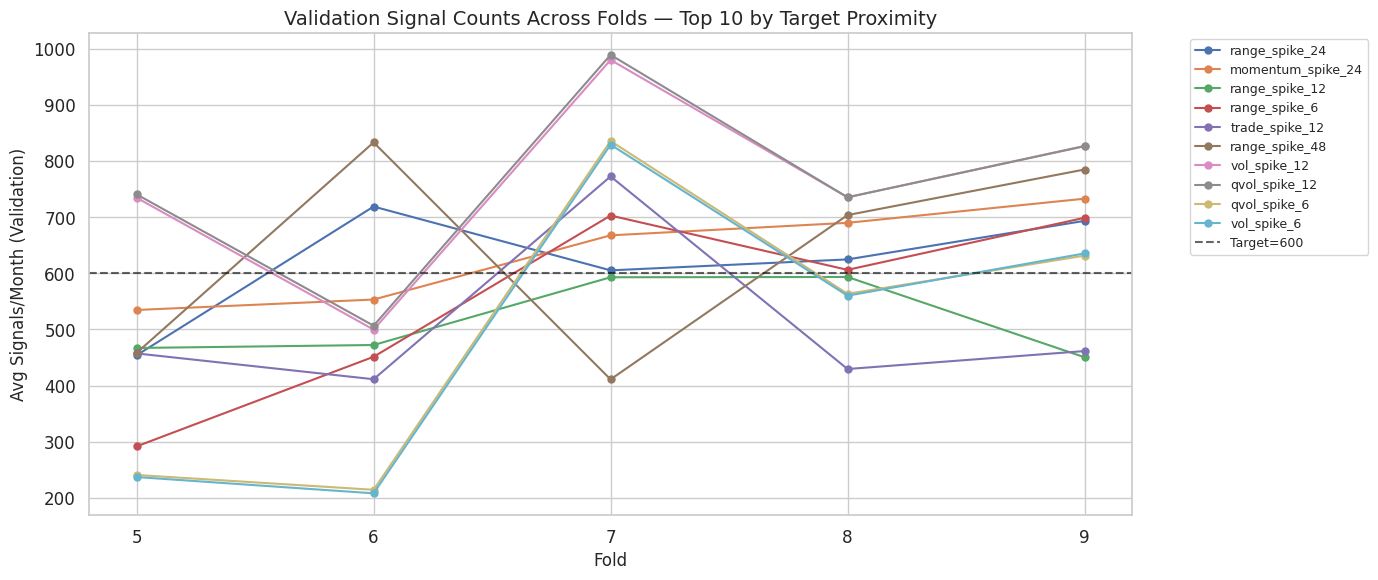

Saved cv_val_signals_lineplot.png


In [8]:
# --- Select top 10 by target proximity (avg |val_avg - 600| / 600 across folds) ---
target_err_by_metric = {}
for metric in METRIC_COLS:
    mdf = cv_df[cv_df["metric"] == metric]
    target_err_by_metric[metric] = (mdf["val_avg"] - TARGET_SIGNALS_MONTH).abs().mean() / TARGET_SIGNALS_MONTH * 100

top10_target = sorted(target_err_by_metric, key=target_err_by_metric.get)[:10]

# --- Heatmap: val_avg signals per fold x metric (top 10) ---
pivot_val = cv_df[cv_df["metric"].isin(top10_target)].pivot(
    index="metric", columns="fold", values="val_avg"
)
pivot_val = pivot_val.loc[[m for m in top10_target if m in pivot_val.index]]

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(
    pivot_val, annot=True, fmt=".0f", cmap="YlOrRd", ax=ax,
    cbar_kws={"label": "Avg Signals/Month (Val)"},
    linewidths=0.5, linecolor="white",
)
ax.set_title("Validation Signal Counts per Fold — Top 10 by Target Proximity")
ax.set_xlabel("Fold")
ax.set_ylabel("")
plt.tight_layout()
fig.savefig(OUTPUT_DIR / "cv_val_signals_heatmap.png")
plt.show()
print("Saved cv_val_signals_heatmap.png")

# --- Line plot: val_avg across folds for top 10 ---
fig, ax = plt.subplots(figsize=(14, 6))
for metric in top10_target:
    mdf = cv_df[cv_df["metric"] == metric]
    ax.plot(mdf["fold"], mdf["val_avg"], marker="o", markersize=5, label=metric)
ax.axhline(TARGET_SIGNALS_MONTH, color="black", ls="--", alpha=0.6, label=f"Target={TARGET_SIGNALS_MONTH}")
ax.set_xlabel("Fold")
ax.set_ylabel("Avg Signals/Month (Validation)")
ax.set_title("Validation Signal Counts Across Folds — Top 10 by Target Proximity")
ax.set_xticks(fold_numbers)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
plt.tight_layout()
fig.savefig(OUTPUT_DIR / "cv_val_signals_lineplot.png")
plt.show()
print("Saved cv_val_signals_lineplot.png")

## Section 8: Drift Analysis (Top 10)

/tmp/ipykernel_2850336/3406120061.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(drift_data, labels=drift_labels, patch_artist=True)


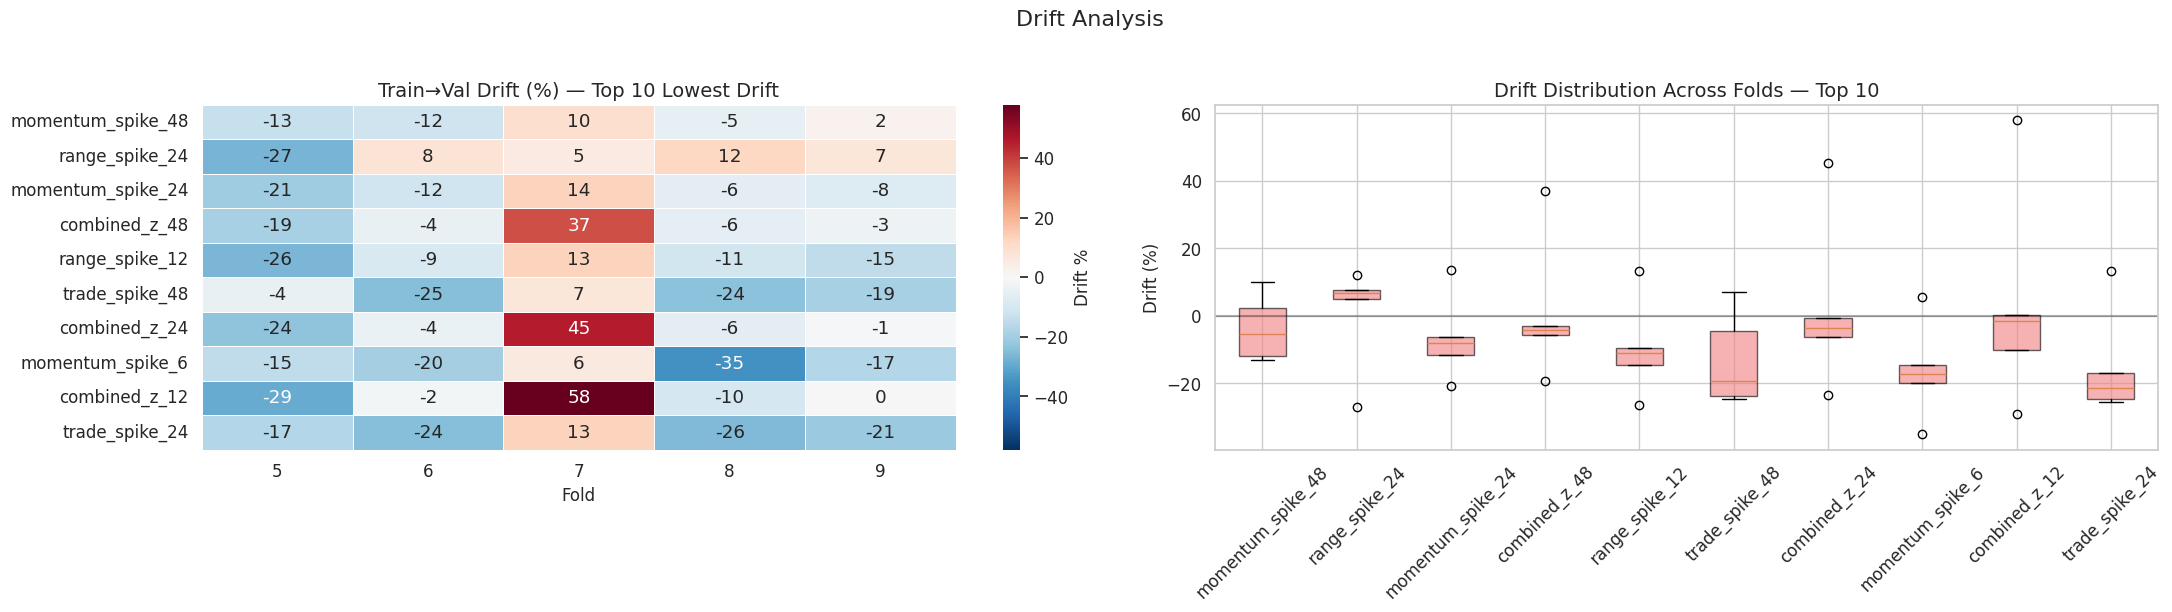

Saved cv_drift_analysis.png


In [9]:
# --- Select top 10 by drift (lowest avg |drift|) ---
drift_by_metric = {}
for metric in METRIC_COLS:
    mdf = cv_df[cv_df["metric"] == metric]
    drift_by_metric[metric] = mdf["drift_pct"].abs().mean()

top10_drift = sorted(drift_by_metric, key=drift_by_metric.get)[:10]

# --- Heatmap: drift_pct per fold x metric (top 10) ---
pivot_drift = cv_df[cv_df["metric"].isin(top10_drift)].pivot(
    index="metric", columns="fold", values="drift_pct"
)
pivot_drift = pivot_drift.loc[[m for m in top10_drift if m in pivot_drift.index]]

fig, axes = plt.subplots(1, 2, figsize=(22, 6))

# Heatmap
ax = axes[0]
vmax = min(pivot_drift.abs().max().max(), 200)
sns.heatmap(
    pivot_drift.clip(-vmax, vmax), annot=True, fmt=".0f",
    cmap="RdBu_r", center=0, ax=ax, vmin=-vmax, vmax=vmax,
    cbar_kws={"label": "Drift %"},
    linewidths=0.5, linecolor="white",
)
ax.set_title("Train→Val Drift (%) — Top 10 Lowest Drift")
ax.set_xlabel("Fold")
ax.set_ylabel("")

# Boxplot of drift across folds per metric (top 10)
ax = axes[1]
drift_data = []
drift_labels = []
for metric in top10_drift:
    vals = cv_df[cv_df["metric"] == metric]["drift_pct"].dropna().values
    drift_data.append(vals)
    drift_labels.append(metric)
bp = ax.boxplot(drift_data, labels=drift_labels, patch_artist=True)
for patch in bp["boxes"]:
    patch.set_facecolor("lightcoral")
    patch.set_alpha(0.6)
ax.axhline(0, color="black", ls="-", alpha=0.3)
ax.set_ylabel("Drift (%)")
ax.set_title("Drift Distribution Across Folds — Top 10")
ax.tick_params(axis="x", rotation=45)

fig.suptitle("Drift Analysis", fontsize=16, y=1.02)
plt.tight_layout()
fig.savefig(OUTPUT_DIR / "cv_drift_analysis.png")
plt.show()
print("Saved cv_drift_analysis.png")

## Section 9: Formula Ranking — 5-Criteria Composite Score

| Criterion | Weight | Direction | Description |
|-----------|--------|-----------|-------------|
| Forward fluctuation | 50% | **higher=better** | avg fwd_fluctuation of triggered val candles (2h window) |
| Stability | 15% | lower=better | avg val CV% across folds |
| Target proximity | 15% | lower=better | avg \|val_avg - 600\| / 600 × 100 |
| Drift | 10% | lower=better | avg \|drift%\| across folds |
| Threshold consistency | 10% | lower=better | CV% of chosen threshold across folds |

In [10]:
ranking_rows = []
for metric in METRIC_COLS:
    mdf = cv_df[cv_df["metric"] == metric]

    # Stability: mean val CV%
    avg_val_cv = mdf["val_cv_pct"].mean()

    # Target proximity: mean |val_avg - target| / target * 100
    target_err = (mdf["val_avg"] - TARGET_SIGNALS_MONTH).abs().mean() / TARGET_SIGNALS_MONTH * 100

    # Drift: mean |drift|%
    avg_abs_drift = mdf["drift_pct"].abs().mean()

    # Threshold consistency: CV% of thresholds across folds
    t_mean = mdf["threshold"].mean()
    t_std = mdf["threshold"].std()
    t_cv = (t_std / t_mean * 100) if t_mean > 0 else np.nan

    # Forward fluctuation: mean across folds
    avg_fwd_fluct = mdf["mean_fwd_fluct"].mean()

    ranking_rows.append({
        "metric": metric,
        "stability": round(avg_val_cv, 1),
        "target_err_pct": round(target_err, 1),
        "avg_abs_drift": round(avg_abs_drift, 1),
        "threshold_cv_pct": round(t_cv, 1) if not np.isnan(t_cv) else np.nan,
        "avg_fwd_fluct": round(avg_fwd_fluct, 6) if not np.isnan(avg_fwd_fluct) else np.nan,
    })

rank_df = pd.DataFrame(ranking_rows).set_index("metric")

# Normalize each criterion to [0, 1]
# Lower=better criteria: standard normalization
for col in ["stability", "target_err_pct", "avg_abs_drift", "threshold_cv_pct"]:
    cmin, cmax = rank_df[col].min(), rank_df[col].max()
    rank_df[f"{col}_norm"] = (rank_df[col] - cmin) / (cmax - cmin + 1e-9)

# Higher=better criterion (fwd_fluct): invert normalization
fmin, fmax = rank_df["avg_fwd_fluct"].min(), rank_df["avg_fwd_fluct"].max()
rank_df["avg_fwd_fluct_norm"] = 1 - (rank_df["avg_fwd_fluct"] - fmin) / (fmax - fmin + 1e-9)

# Weighted composite score (lower = better)
# Forward fluctuation dominates at 50% — prioritizes signal quality
rank_df["composite_score"] = (
    0.50 * rank_df["avg_fwd_fluct_norm"] +
    0.15 * rank_df["stability_norm"] +
    0.15 * rank_df["target_err_pct_norm"] +
    0.10 * rank_df["avg_abs_drift_norm"] +
    0.10 * rank_df["threshold_cv_pct_norm"]
)
rank_df = rank_df.sort_values("composite_score")
rank_df["rank"] = range(1, len(rank_df) + 1)

top_formula = rank_df.index[0]
print(f"Top formula: {top_formula} (composite = {rank_df['composite_score'].iloc[0]:.3f})")

# Save
save_cols = ["stability", "target_err_pct", "avg_abs_drift", "threshold_cv_pct",
             "avg_fwd_fluct", "composite_score", "rank"]
rank_df[save_cols].to_csv(OUTPUT_DIR / "threshold_cv_formula_ranking.csv")
print("Saved threshold_cv_formula_ranking.csv")
rank_df[save_cols].head(15)

Top formula: range_spike_48 (composite = 0.243)
Saved threshold_cv_formula_ranking.csv


,stability,target_err_pct,avg_abs_drift,threshold_cv_pct,avg_fwd_fluct,composite_score,rank
metric,,,,,,,
range_spike_48,55.9,28.4,22.4,3.8,0.043011,0.243216,1
range_spike_24,51.6,13.0,11.7,4.1,0.032236,0.366897,2
momentum_spike_48,47.5,141.3,8.5,0.0,0.024873,0.385390,3
trade_spike_48,45.5,224.1,15.8,0.0,0.021501,0.447797,4
momentum_spike_24,49.8,13.4,12.0,0.0,0.021050,0.459369,5
trade_spike_24,47.2,75.2,20.3,0.0,0.019741,0.477722,6
range_spike_12,52.6,14.1,14.9,2.6,0.024469,0.487148,7
vol_spike_24,43.2,260.8,27.1,0.0,0.017528,0.515617,8
qvol_spike_24,42.8,261.1,27.6,0.0,0.017307,0.515896,9


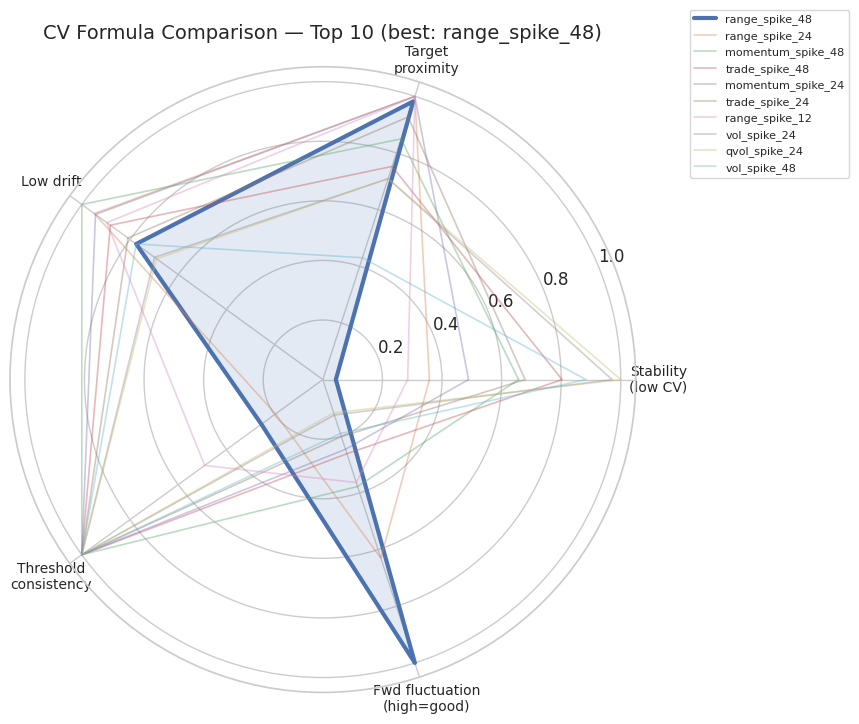

Saved cv_formula_radar.png


In [11]:
# --- Radar chart — top 10 metrics only ---
top10_metrics = rank_df.index[:10].tolist()

categories = ["Stability\n(low CV)", "Target\nproximity", "Low drift",
              "Threshold\nconsistency", "Fwd fluctuation\n(high=good)"]
N_cat = len(categories)
angles = np.linspace(0, 2 * np.pi, N_cat, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))

for metric in top10_metrics:
    values = [
        1 - rank_df.loc[metric, "stability_norm"],
        1 - rank_df.loc[metric, "target_err_pct_norm"],
        1 - rank_df.loc[metric, "avg_abs_drift_norm"],
        1 - rank_df.loc[metric, "threshold_cv_pct_norm"],
        1 - rank_df.loc[metric, "avg_fwd_fluct_norm"],
    ]
    values += values[:1]
    lw = 3 if metric == top_formula else 1.2
    alpha = 1.0 if metric == top_formula else 0.4
    ax.plot(angles, values, linewidth=lw, alpha=alpha, label=metric)
    if metric == top_formula:
        ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_ylim(0, 1.05)
ax.set_title(f"CV Formula Comparison — Top 10 (best: {top_formula})", fontsize=14, pad=20)
ax.legend(bbox_to_anchor=(1.35, 1.1), fontsize=8)
plt.tight_layout()
fig.savefig(OUTPUT_DIR / "cv_formula_radar.png")
plt.show()
print("Saved cv_formula_radar.png")

## Section 10: Comparison with Original 50/50 Split

In [12]:
# --- Comparison with original 50/50 split ---
# The metric set has changed (taker_imbalance removed, momentum_spike added,
# multi-window variants introduced), so direct rank comparison is not meaningful.
orig_path = OUTPUT_DIR / "threshold_formula_ranking.csv"
if orig_path.exists():
    orig_rank = pd.read_csv(orig_path, index_col="metric")
    print("Original 50/50 split ranking (from threshold_analysis.ipynb):")
    display(orig_rank[["avg_cv", "abs_drift", "target_err_pct", "composite_score", "rank"]])
    print("\nNOTE: Direct rank comparison is not applicable.")
    print("  - Original used 7 metrics (single window, included taker_imbalance)")
    print("  - Current CV uses 25 metrics (4 windows, momentum_spike replaces taker_imbalance)")
    print("  - Coverage filtering and fwd_fluctuation criterion are new")
    print("  - The metric namespaces are incompatible (e.g. 'vol_spike' vs 'vol_spike_12')")
else:
    print("Original ranking file not found — skipping comparison.")

print(f"\nCurrent CV ranking — top 10:")
display(rank_df[save_cols].head(10))

Original 50/50 split ranking (from threshold_analysis.ipynb):


,avg_cv,abs_drift,target_err_pct,composite_score,rank
metric,,,,,
range_spike,92.7,18.7,8.4,0.066700,1
trade_spike,94.0,42.8,6.8,0.278816,2
combined_z,85.4,54.8,295.3,0.306003,3
qvol_spike,101.7,44.3,27.4,0.362029,4
vol_spike,101.8,44.8,27.9,0.367108,5
price_move,129.2,20.6,384.8,0.423655,6
taker_imbalance,93.8,54.0,14425.0,0.670064,7



NOTE: Direct rank comparison is not applicable.
  - Original used 7 metrics (single window, included taker_imbalance)
  - Current CV uses 25 metrics (4 windows, momentum_spike replaces taker_imbalance)
  - Coverage filtering and fwd_fluctuation criterion are new
  - The metric namespaces are incompatible (e.g. 'vol_spike' vs 'vol_spike_12')

Current CV ranking — top 10:


,stability,target_err_pct,avg_abs_drift,threshold_cv_pct,avg_fwd_fluct,composite_score,rank
metric,,,,,,,
range_spike_48,55.9,28.4,22.4,3.8,0.043011,0.243216,1
range_spike_24,51.6,13.0,11.7,4.1,0.032236,0.366897,2
momentum_spike_48,47.5,141.3,8.5,0.0,0.024873,0.385390,3
trade_spike_48,45.5,224.1,15.8,0.0,0.021501,0.447797,4
momentum_spike_24,49.8,13.4,12.0,0.0,0.021050,0.459369,5
trade_spike_24,47.2,75.2,20.3,0.0,0.019741,0.477722,6
range_spike_12,52.6,14.1,14.9,2.6,0.024469,0.487148,7
vol_spike_24,43.2,260.8,27.1,0.0,0.017528,0.515617,8
qvol_spike_24,42.8,261.1,27.6,0.0,0.017307,0.515896,9


## Section 11: Deep Dive on Top Formula

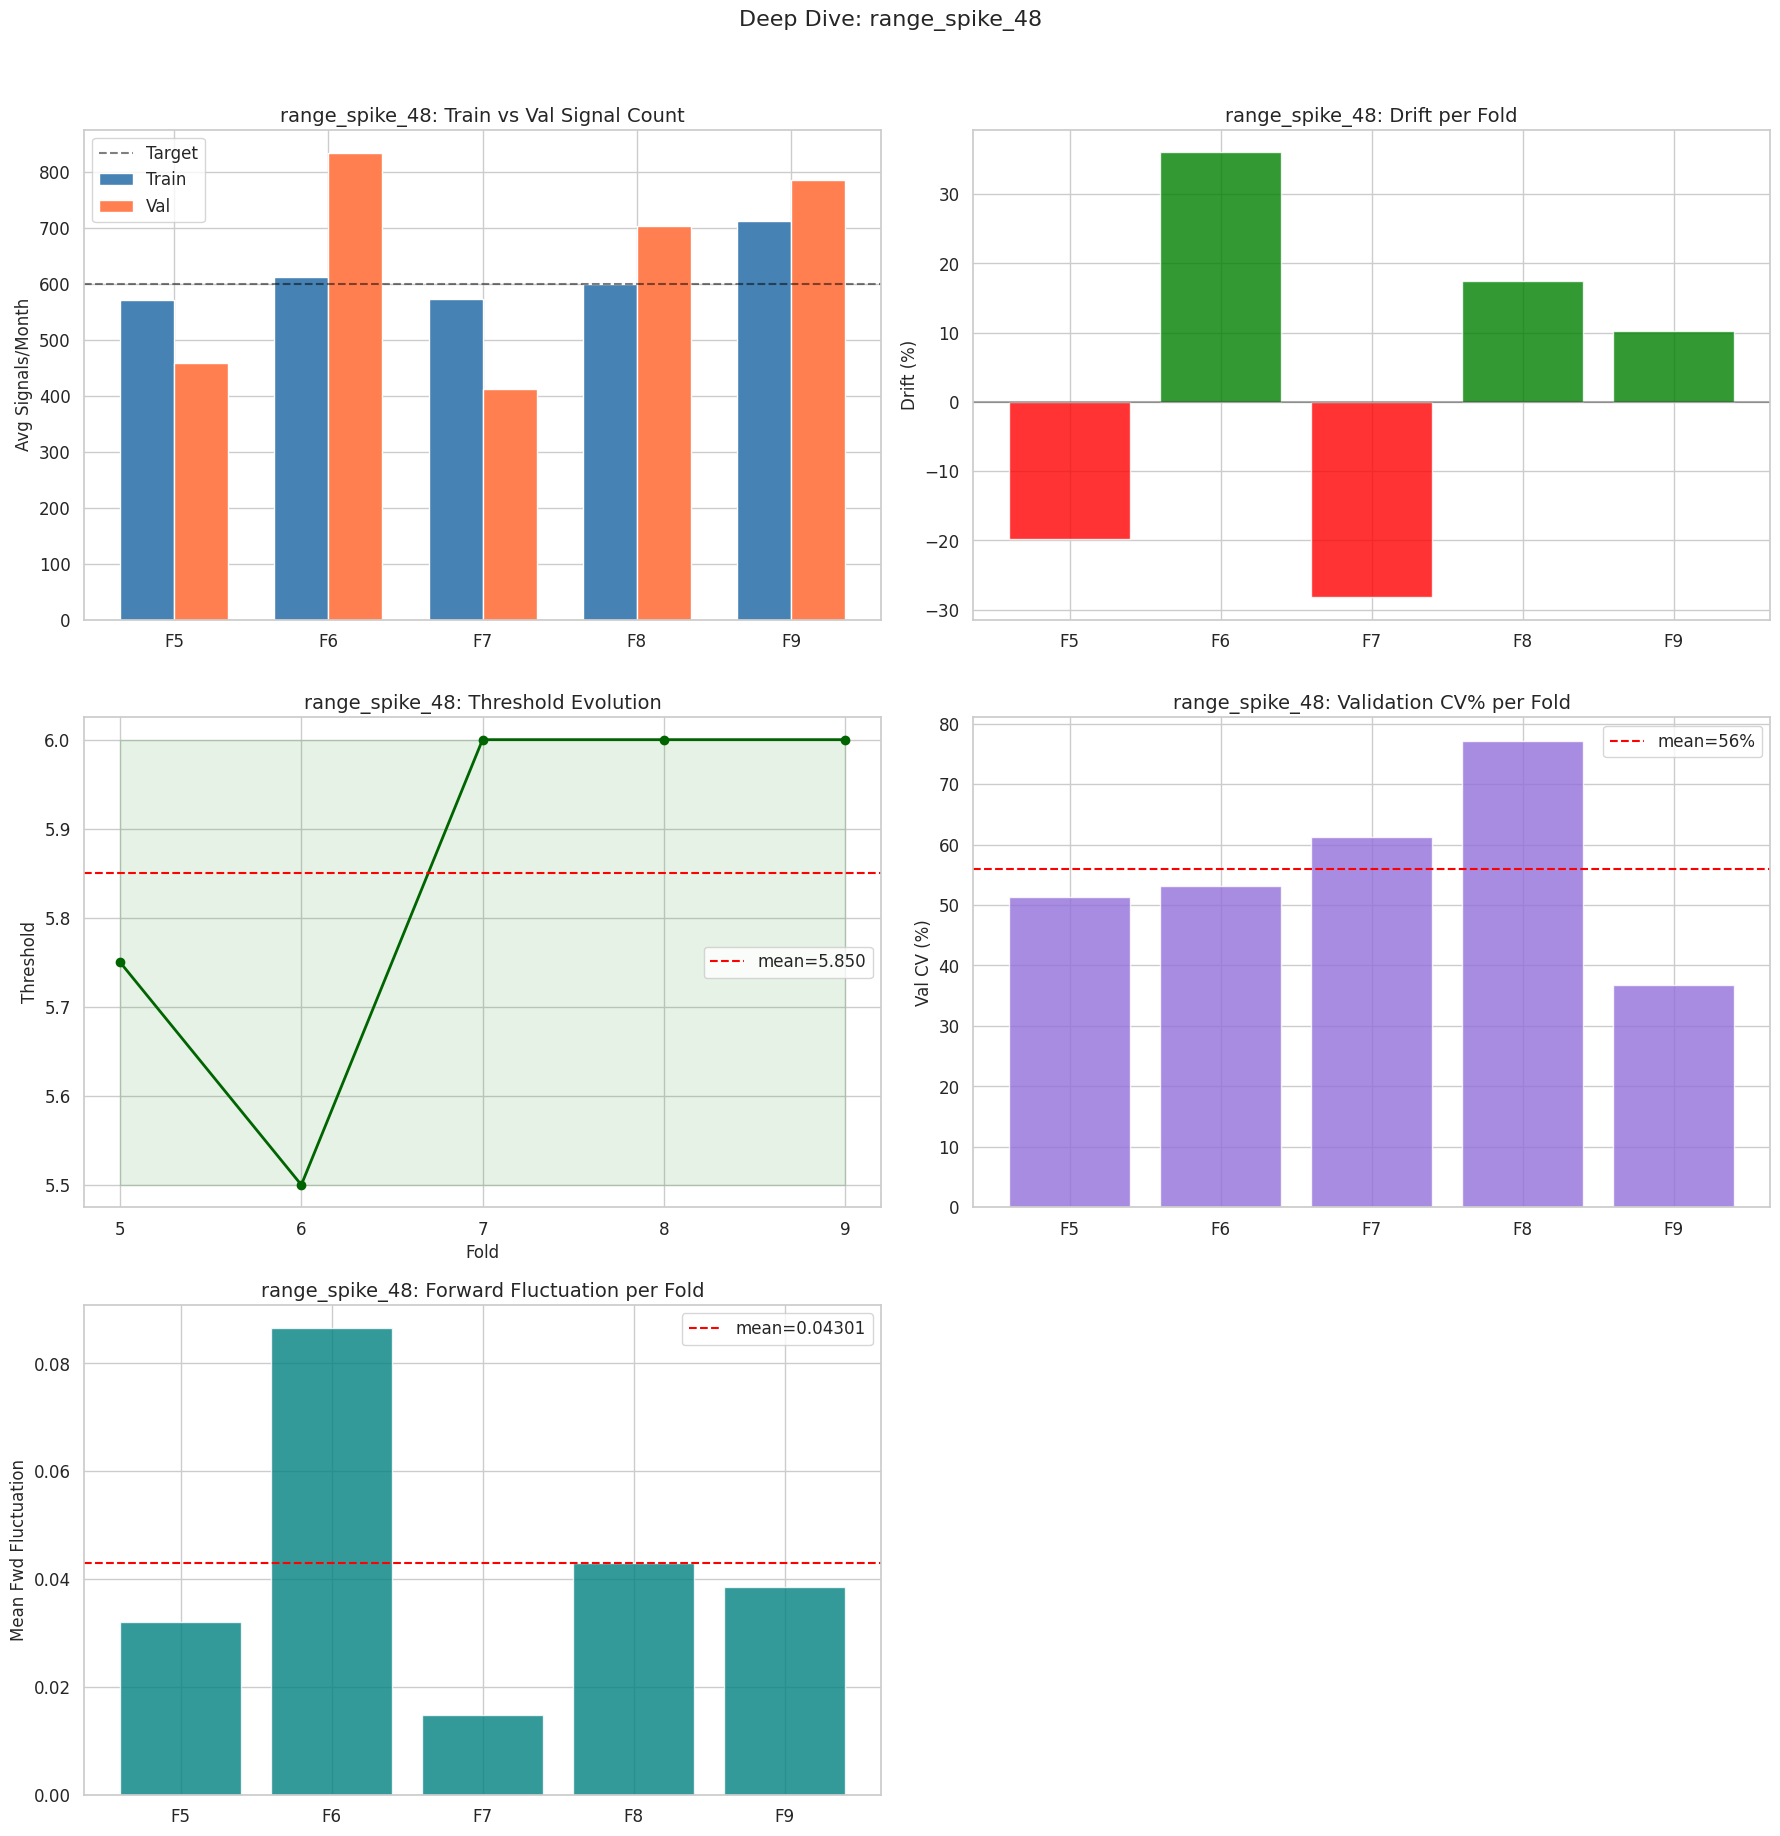

Saved cv_top_formula_detail.png


In [13]:
top_df = cv_df[cv_df["metric"] == top_formula].copy()
folds = top_df["fold"].values

fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# 1. Train vs Val avg signals per fold
ax = axes[0, 0]
x = np.arange(len(folds))
w = 0.35
ax.bar(x - w/2, top_df["train_avg"], w, label="Train", color="steelblue")
ax.bar(x + w/2, top_df["val_avg"], w, label="Val", color="coral")
ax.axhline(TARGET_SIGNALS_MONTH, color="black", ls="--", alpha=0.5, label="Target")
ax.set_xticks(x)
ax.set_xticklabels([f"F{f}" for f in folds])
ax.set_ylabel("Avg Signals/Month")
ax.set_title(f"{top_formula}: Train vs Val Signal Count")
ax.legend()

# 2. Drift per fold
ax = axes[0, 1]
colors = ["green" if d >= 0 else "red" for d in top_df["drift_pct"]]
ax.bar(x, top_df["drift_pct"], color=colors, alpha=0.8)
ax.axhline(0, color="black", ls="-", alpha=0.3)
ax.set_xticks(x)
ax.set_xticklabels([f"F{f}" for f in folds])
ax.set_ylabel("Drift (%)")
ax.set_title(f"{top_formula}: Drift per Fold")

# 3. Threshold evolution
ax = axes[1, 0]
ax.plot(folds, top_df["threshold"], marker="o", linewidth=2, color="darkgreen")
ax.fill_between(folds, top_df["threshold"].min(), top_df["threshold"].max(),
                alpha=0.1, color="green")
ax.axhline(top_df["threshold"].mean(), color="red", ls="--",
           label=f"mean={top_df['threshold'].mean():.3f}")
ax.set_xlabel("Fold")
ax.set_ylabel("Threshold")
ax.set_title(f"{top_formula}: Threshold Evolution")
ax.set_xticks(folds)
ax.legend()

# 4. Val CV% per fold
ax = axes[1, 1]
ax.bar(x, top_df["val_cv_pct"].fillna(0), color="mediumpurple", alpha=0.8)
ax.axhline(top_df["val_cv_pct"].mean(), color="red", ls="--",
           label=f"mean={top_df['val_cv_pct'].mean():.0f}%")
ax.set_xticks(x)
ax.set_xticklabels([f"F{f}" for f in folds])
ax.set_ylabel("Val CV (%)")
ax.set_title(f"{top_formula}: Validation CV% per Fold")
ax.legend()

# 5. Forward fluctuation per fold
ax = axes[2, 0]
fluct_vals = top_df["mean_fwd_fluct"].fillna(0).values
ax.bar(x, fluct_vals, color="teal", alpha=0.8)
ax.axhline(np.nanmean(top_df["mean_fwd_fluct"]), color="red", ls="--",
           label=f"mean={np.nanmean(top_df['mean_fwd_fluct']):.5f}")
ax.set_xticks(x)
ax.set_xticklabels([f"F{f}" for f in folds])
ax.set_ylabel("Mean Fwd Fluctuation")
ax.set_title(f"{top_formula}: Forward Fluctuation per Fold")
ax.legend()

# 6. Hide unused subplot
axes[2, 1].set_visible(False)

fig.suptitle(f"Deep Dive: {top_formula}", fontsize=16, y=1.02)
plt.tight_layout()
fig.savefig(OUTPUT_DIR / "cv_top_formula_detail.png")
plt.show()
print("Saved cv_top_formula_detail.png")

## Section 12: Conclusions

In [14]:
print("=" * 80)
print("TIME-SERIES CROSS-VALIDATION — SUMMARY")
print("=" * 80)

print(f"\nSetup: {N_SEGMENTS} segments, {len(valid_folds)}/{N_FOLDS} valid folds "
      f"(≥{MIN_COVERAGE_RATIO:.0%} coverage), {len(symbols)} symbols")
print(f"Metrics: {len(METRIC_COLS)} total ({len(_BASE_METRICS)} bases × {len(WINDOWS)} windows + price_move)")
print(f"Windows: {WINDOWS} (30min, 1h, 2h, 4h)")

# Coverage filtering stats
n_skipped = N_FOLDS - len(valid_folds)
print(f"\nCOVERAGE FILTERING:")
print(f"  Folds skipped: {n_skipped} (had <{MIN_COVERAGE_RATIO:.0%} of {TOTAL_SYMBOLS} symbols)")
print(f"  Valid folds used: {[f+1 for f in valid_folds]}")

print(f"\n1. TOP 10 FORMULA RANKING (of {len(METRIC_COLS)}, best to worst):")
for i, (metric, row) in enumerate(rank_df[save_cols].head(10).iterrows(), 1):
    marker = " <<<" if metric == top_formula else ""
    print(f"   {i:2d}. {metric:22s}  score={row['composite_score']:.3f}  "
          f"stab={row['stability']:.0f}%  target_err={row['target_err_pct']:.0f}%  "
          f"drift={row['avg_abs_drift']:.0f}%  t_cv={row['threshold_cv_pct']:.0f}%  "
          f"fwd_fluct={row['avg_fwd_fluct']:.5f}{marker}")

# Best metric per window
print(f"\n2. BEST METRIC PER WINDOW:")
for w in WINDOWS:
    window_metrics = [m for m in rank_df.index if m.endswith(f"_{w}")]
    if window_metrics:
        best_w = window_metrics[0]  # already sorted by composite
        r = rank_df.loc[best_w]
        print(f"   Window {w:2d} ({w*5:3d}min): {best_w:22s}  rank={int(r['rank']):2d}  "
              f"score={r['composite_score']:.3f}")
# price_move (no window)
if "price_move" in rank_df.index:
    r = rank_df.loc["price_move"]
    print(f"   No window:    {'price_move':22s}  rank={int(r['rank']):2d}  "
          f"score={r['composite_score']:.3f}")

print(f"\n3. TOP FORMULA: {top_formula}")
top_row = rank_df.loc[top_formula]
top_mdf = cv_df[cv_df["metric"] == top_formula]
print(f"   Avg threshold across folds: {top_mdf['threshold'].mean():.3f} "
      f"(range: {top_mdf['threshold'].min():.3f}–{top_mdf['threshold'].max():.3f})")
print(f"   Avg val signals/month: {top_mdf['val_avg'].mean():.0f}")
print(f"   Avg drift: {top_mdf['drift_pct'].mean():.1f}%")
print(f"   Avg fwd fluctuation: {top_mdf['mean_fwd_fluct'].mean():.5f}")

print(f"\n4. NEXT STEPS:")
print(f"   - Use {top_formula} with threshold ~{top_mdf['threshold'].mean():.2f} as primary filter")
print(f"   - Compare window variants of the top base metric")
print(f"   - Test entry/exit strategies conditioned on threshold signals")

print("\n" + "=" * 80)

TIME-SERIES CROSS-VALIDATION — SUMMARY

Setup: 12 segments, 5/11 valid folds (≥80% coverage), 118 symbols
Metrics: 25 total (6 bases × 4 windows + price_move)
Windows: [6, 12, 24, 48] (30min, 1h, 2h, 4h)

COVERAGE FILTERING:
  Folds skipped: 6 (had <80% of 118 symbols)
  Valid folds used: [5, 6, 7, 8, 9]

1. TOP 10 FORMULA RANKING (of 25, best to worst):
    1. range_spike_48          score=0.243  stab=56%  target_err=28%  drift=22%  t_cv=4%  fwd_fluct=0.04301 <<<
    2. range_spike_24          score=0.367  stab=52%  target_err=13%  drift=12%  t_cv=4%  fwd_fluct=0.03224
    3. momentum_spike_48       score=0.385  stab=48%  target_err=141%  drift=8%  t_cv=0%  fwd_fluct=0.02487
    4. trade_spike_48          score=0.448  stab=46%  target_err=224%  drift=16%  t_cv=0%  fwd_fluct=0.02150
    5. momentum_spike_24       score=0.459  stab=50%  target_err=13%  drift=12%  t_cv=0%  fwd_fluct=0.02105
    6. trade_spike_24          score=0.478  stab=47%  target_err=75%  drift=20%  t_cv=0%  fwd_fluc